In [1]:
import requests
import random
import numpy as np
import pandas as pd
import torch
import torchvision
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from timeit import default_timer as timer 
from pathlib import Path 
from torch import nn
from torchvision import datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader

if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import accuracy_fn

## Downloading & Understanding the Dataset

In [2]:
train_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
    target_transform=None
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 26.4M/26.4M [00:01<00:00, 17.4MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 304kB/s]
100%|██████████| 4.42M/4.42M [00:00<00:00, 5.63MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 8.30MB/s]


In [3]:
image, label = train_data[0]

In [4]:
# [color_channels=1, height=28, width=28]
# color_channels=1 => greyscale
image.shape

torch.Size([1, 28, 28])

In [5]:
image

tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0039, 0.0000, 0.0000, 0.0510,
          0.2863, 0.0000, 0.0000, 0.0039, 0.0157, 0.0000,

In [6]:
label

9

In [7]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [8]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## Visualizing Data

Text(0.5, 1.0, '9')

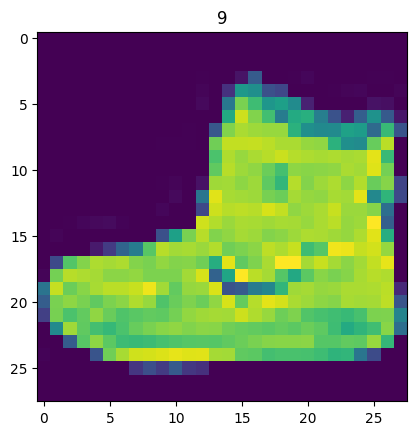

In [9]:
image, label = train_data[0]
plt.imshow(image.squeeze())
plt.title(label)

Text(0.5, 1.0, 'Ankle boot')

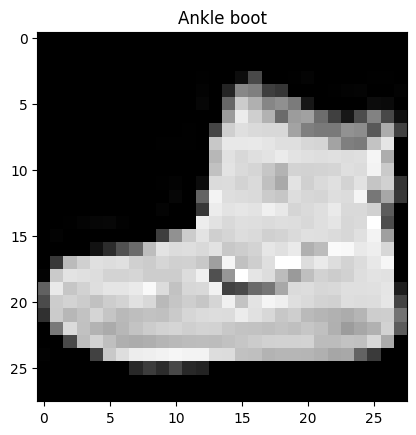

In [10]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(class_names[label])

## Data Loader

In [11]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=True)

print(f"Training batches: {len(train_dataloader)} with {BATCH_SIZE} samples")
print(f"Test batches: {len(test_dataloader)} with {BATCH_SIZE} samples")

Training batches: 1875 with 32 samples
Test batches: 313 with 32 samples


## Linear Model

In [12]:
# Feature Vector: Flatten - [color_channels, height, width] shape to [color_channels, height*width] shape.
# From height and width dimensions to one feature vector

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layers(x)

## Linear Model: Training & Test

In [13]:
model = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))
model

FashionMNISTModelV0(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.1)

In [15]:
def print_train_time(start: float, end: float):
    """
    Prints difference between start and end time.
    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time: {total_time:.3f} seconds")
    return total_time

In [16]:
epochs = 3
train_time_start = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n-------")

    train_loss = 0

    for batch, (X, y) in enumerate(train_dataloader):
        model.train()
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")

    train_loss /= len(train_dataloader)
    test_loss = 0
    test_acc = 0

    model.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            test_y_pred = model(X)
            test_loss += criterion(test_y_pred, y)
            test_acc += accuracy_fn(y_pred=test_y_pred.argmax(dim=1), y_true=y)

        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)

    print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")

train_time_end = timer()
total_train_time_model = print_train_time(start=train_time_start, end=train_time_end)
total_train_time_model

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.58396 | Test loss: 0.49263, Test acc: 82.89%

Epoch: 1
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.47445 | Test loss: 0.48622, Test acc: 83.00%

Epoch: 2
-------
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples

Train loss: 0.45465 | Test loss: 0.49316, Test acc: 83.05%

Train time: 26.845 seconds


26.845313043000033

## Evaluation Function

In [17]:
def eval_model(model: nn.Module, data_loader: DataLoader, criterion: nn.Module, accuracy_fn):
    loss, acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)
            loss += criterion(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
            "model_loss": loss.item(),
            "model_acc": acc}

In [18]:
model_results = eval_model(
    model=model,
    data_loader=test_dataloader,
    criterion=criterion,
    accuracy_fn=accuracy_fn
)

model_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.49334555864334106,
 'model_acc': 83.02715654952077}

## Non-Linear Model

In [19]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layers(x)

In [20]:
model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names))
model_1

FashionMNISTModelV1(
  (layers): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [22]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               criterion: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn):
    train_loss, train_acc = 0, 0

    for batch, (X, y) in enumerate(data_loader):
        y_pred = model(X)
        loss = criterion(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              criterion: torch.nn.Module,
              accuracy_fn):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode(): 
        for X, y in data_loader:
            test_pred = model(X)
            test_loss += criterion(test_pred, y)
            test_acc += accuracy_fn(y_true=y, y_pred=test_pred.argmax(dim=1))
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [23]:
train_time_start = timer()
epochs = 3

for epoch in range(epochs):
    print(f"Epoch: {epoch}\n---------")
    train_step(
        model=model_1,
        data_loader=train_dataloader,
        criterion=criterion,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(
        model=model_1,
        data_loader=test_dataloader,
        criterion=criterion,
        accuracy_fn=accuracy_fn
    )

train_time_end = timer()
total_train_time_model_1 = print_train_time(start=train_time_start, end=train_time_end)

Epoch: 0
---------
Train loss: 1.19824 | Train accuracy: 57.47%
Test loss: 1.10928 | Test accuracy: 59.71%

Epoch: 1
---------
Train loss: 1.08028 | Train accuracy: 60.29%
Test loss: 1.08937 | Test accuracy: 59.98%

Epoch: 2
---------
Train loss: 1.05562 | Train accuracy: 60.94%
Test loss: 1.07304 | Test accuracy: 60.33%

Train time: 27.247 seconds


In [24]:
model_1_results = eval_model(
    model=model_1, 
    data_loader=test_dataloader,
    criterion=criterion, 
    accuracy_fn=accuracy_fn
)

model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 1.0739291906356812,
 'model_acc': 60.3035143769968}

## CNN Model

In [25]:
class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()

        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        
        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units * 7 * 7, out_features=output_shape)
        )

    def forward(self, x):
        return self.classifier(self.block_2(self.block_1(x)))

In [26]:
model_2 = FashionMNISTModelV2(
    input_shape=1, 
    hidden_units=10, 
    output_shape=len(class_names)
)

model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [27]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.1)

In [28]:
train_time_start = timer()
epochs = 3

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n---------")
    train_step(data_loader=train_dataloader, 
        model=model_2, 
        criterion=criterion,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )

    test_step(data_loader=test_dataloader,
        model=model_2,
        criterion=criterion,
        accuracy_fn=accuracy_fn
    )

train_time_end = timer()
total_train_time_model_2 = print_train_time(start=train_time_start, end=train_time_end)

  0%|          | 0/3 [00:00<?, ?it/s]

Epoch: 0
---------
Train loss: 0.64623 | Train accuracy: 76.67%
Test loss: 0.41476 | Test accuracy: 85.26%

Epoch: 1
---------
Train loss: 0.36143 | Train accuracy: 86.86%
Test loss: 0.37271 | Test accuracy: 86.65%

Epoch: 2
---------
Train loss: 0.32414 | Train accuracy: 88.28%
Test loss: 0.35964 | Test accuracy: 86.80%

Train time: 98.366 seconds


In [29]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    criterion=criterion,
    accuracy_fn=accuracy_fn
)

model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3600190281867981,
 'model_acc': 86.78115015974441}

## Model Comparison

In [30]:
compare_results = pd.DataFrame([model_results, model_1_results, model_2_results])
compare_results

,model_name,model_loss,model_acc
0,FashionMNISTModelV0,0.493346,83.027157
1,FashionMNISTModelV1,1.073929,60.303514
2,FashionMNISTModelV2,0.360019,86.781150


In [31]:
compare_results["training_time"] = [total_train_time_model,
                                    total_train_time_model_1,
                                    total_train_time_model_2]
compare_results

,model_name,model_loss,model_acc,training_time
0,FashionMNISTModelV0,0.493346,83.027157,26.845313
1,FashionMNISTModelV1,1.073929,60.303514,27.247446
2,FashionMNISTModelV2,0.360019,86.781150,98.365902


## Making Predictions

In [53]:
shape = len(test_samples), len(test_samples[0]), len(test_samples[0][0]), len(test_samples[0][0][0])
sample = torch.unsqueeze(test_samples[0], dim=0)
sample_shape = len(sample), len(sample[0]), len(sample[0][0]), len(sample[0][0][0])
print(f"Test shape: {shape}, Sample shape: {sample_shape}")

Test shape: (9, 1, 28, 28), Sample shape: (1, 1, 28, 28)


In [59]:
def make_predictions(model: torch.nn.Module, data: list):
    pred_probs = []
    model.eval()

    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob)

    return torch.stack(pred_probs)

In [55]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [60]:
pred_probs = make_predictions(model=model_2, data=test_samples)
pred_probs

tensor([[5.2326e-02, 3.8844e-07, 5.4828e-04, 3.3512e-06, 1.6493e-03, 1.4114e-06,
         1.6376e-03, 2.5784e-06, 9.4383e-01, 3.4084e-06],
        [3.8667e-04, 2.8563e-06, 5.0131e-04, 4.8650e-03, 9.7944e-01, 2.1479e-08,
         1.3337e-02, 5.6422e-08, 1.4698e-03, 1.7477e-07],
        [7.1149e-07, 9.9995e-01, 1.0036e-08, 1.5497e-05, 3.6626e-05, 1.6628e-08,
         4.2660e-07, 1.0638e-08, 6.0159e-07, 1.1934e-08],
        [3.9363e-05, 1.3816e-07, 9.6528e-05, 1.4029e-06, 5.5676e-06, 1.8067e-03,
         8.0464e-05, 4.4338e-04, 2.4979e-04, 9.9728e-01],
        [2.7551e-05, 8.8300e-07, 6.2259e-06, 3.0926e-06, 2.9162e-04, 4.2724e-07,
         3.4290e-04, 3.7677e-06, 9.9930e-01, 2.1243e-05],
        [2.1867e-03, 1.3175e-04, 1.9843e-02, 3.6641e-03, 1.3438e-01, 4.2977e-06,
         8.2769e-01, 7.3651e-06, 1.2069e-02, 2.6570e-05],
        [8.7154e-10, 3.4959e-12, 1.9979e-10, 5.2742e-12, 1.3858e-11, 1.0000e+00,
         5.2203e-10, 2.8638e-10, 7.5440e-09, 9.1886e-10],
        [7.0945e-04, 2.4152

In [61]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([8, 4, 1, 9, 8, 6, 5, 8, 6])

In [63]:
test_labels, pred_classes

([8, 4, 1, 9, 8, 6, 5, 8, 0], tensor([8, 4, 1, 9, 8, 6, 5, 8, 6]))

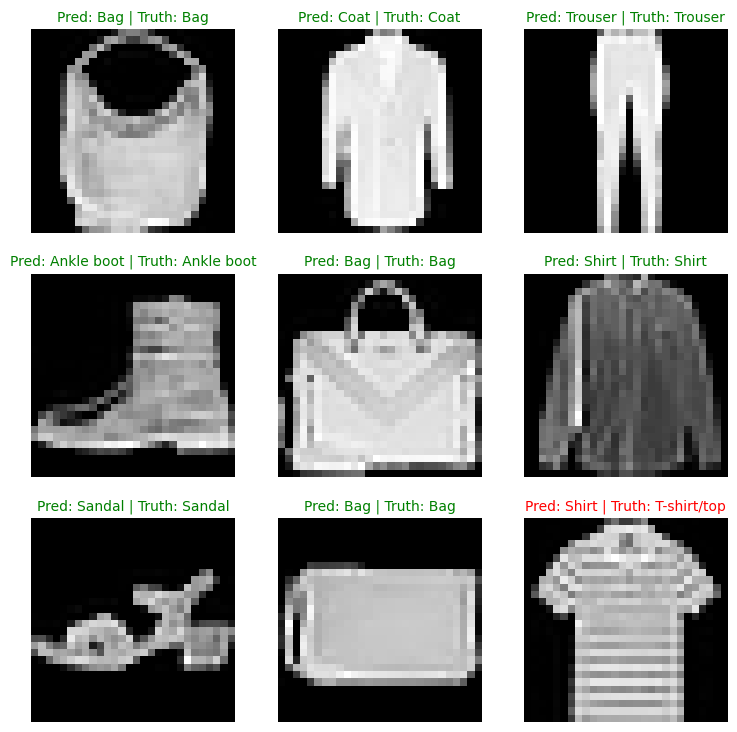

In [64]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]] 
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g") # green text if correct
    else:
        plt.title(title_text, fontsize=10, c="r") # red text if wrong
  
    plt.axis(False);